In [1]:
from vlab._utils import load_yaml_file
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 14

config = load_yaml_file('config.yaml')
config

{'commit': '552527eb3f85d3a1bbb817c5f4b5c67d30bf6936', 'experiment_tag': 'sweep_nn', 'n_tr': 1000, 'n_trs': 'np.logspace(2.302,3.699,20).astype(int)', 'hidden_layer_sizes': '(100,100,)', 'alpha': 1.25, 'gamma': '2/3', 'tau': 0.2, 'taus': 'np.linspace(0.05,1.00, 20)', 'n_te': 1000, 'max_iter': 2000, 'replicate': 1, 'method': 'mlp', 'sweep': 'tau', 'run_protocol': ['plot_figure.ipynb'], 'results': ['a2686d2c7be3e7594a4479e33376b7e5a5c525c4', '82f1e20ae4d56d0ad4d1fb4777197dcb20a823ff'], 'archive_path': '/home/yutongw/projects/Near-interpolators/paper_figures/archive'}

In [2]:
import pandas as pd
import os

In [3]:

# for res_hash in config['results']:
def get_df_from_res_hash(res_hash):
    print(res_hash)
    csv_files = os.listdir(f"{config['archive_path']}/{res_hash}/outputs")
    df = pd.concat([pd.read_csv(f"{config['archive_path']}/{res_hash}/outputs/{csv_file}") for csv_file in csv_files])
    # dfs.append(pd.read_csv(f"{config['archive_path']}/{res_hash}"))
    return df
import vlab
def get_config_from_res_hash(res_hash):
    print(res_hash)
    return vlab.utils.load_yaml_file(f"{config['archive_path']}/{res_hash}/config.yaml")


In [4]:
from test_error_analytic_form import get_risk_predictors, k_grid, get_E_tr_inv

from binary_search import binary_search
colors = ['#1E88E5', '#D81B60']
colorsL= ['#A5D5FF','#FF86B2']
import numpy as np
def plot_trade_off_curve(gamma, alpha, **kwargs):
    E_te, E_tr, R = get_risk_predictors(gamma, alpha)
    k_crit = binary_search(R,0,n_steps=30, init=1.5, LB=1.0, UB= 2.0)
    ks = np.logspace(np.log10(k_crit), 4, num=100)
    E_tr_inv = get_E_tr_inv(gamma,alpha)
    ks = np.array([E_tr_inv(tau) for tau in np.linspace(0.001,0.98,100)])
    # plt.scatter(df["rreg_E_tr"], df["rreg_E_te"],color = '#1f77b4',label='near-interpol-RR')
    
    
    plt.plot(E_tr(ks),E_te(ks),**kwargs)
    # ks = np.array([E_tr_inv(tau) for tau in np.linspace(0.001,0.98,20)])
    # plt.scatter(E_tr(ks),E_te(ks))

In [5]:
def annote_box(text, xy, xytext, color):
    ax = plt.gca()
    ax.annotate(text, 
                xy=xy, 
                xycoords='data',
                xytext=xytext, 
                textcoords='offset points',
                arrowprops=dict(arrowstyle="->", color=color),
                color=color,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor=color))



a2686d2c7be3e7594a4479e33376b7e5a5c525c4
a2686d2c7be3e7594a4479e33376b7e5a5c525c4
82f1e20ae4d56d0ad4d1fb4777197dcb20a823ff
82f1e20ae4d56d0ad4d1fb4777197dcb20a823ff


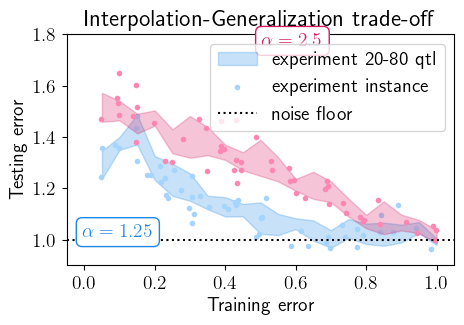

In [11]:
debug = False

plt.figure(figsize=(5,3))
xys = [ (0.0,1.0), (0.5,1.75)]
xytexts = [ (-1.6,1.9), (0.7,1.0)]

for i in range(len(config['results'])):
    res_hash = config['results'][i]
    df = get_df_from_res_hash(res_hash)
    
    run_config = get_config_from_res_hash(res_hash)
    alpha_lab = r'$\alpha = ' +str(run_config['alpha'])+ '$'
    
    medians = df.groupby('tau')[['E_tr', 'E_te']].median().reset_index()
    quantiles_20 = df.groupby('tau')[['E_tr', 'E_te']].quantile(0.20).reset_index()
    quantiles_80 = df.groupby('tau')[['E_tr', 'E_te']].quantile(0.80).reset_index()
    annote_box(alpha_lab, xy = xys[i],xytext= xytexts[i], color=colors[i])

    if i == 0:
        qtl_label = 'experiment 20-80 qtl'
        scatter_label = 'experiment instance'
        curve_label = 'theoretical prediction'
    else:
        qtl_label = None
        scatter_label = None
        curve_label = None
    plt.fill_between(quantiles_20['tau'], quantiles_20['E_te'], quantiles_80['E_te'], color=colors[i], alpha=0.25, label=qtl_label)

    df_small = df.sample(frac=0.25)
    
    plt.scatter(df_small['E_tr'], df_small['E_te'],color=colorsL[i], marker='.', label=scatter_label)
    
    # plot_trade_off_curve(gamma=eval(run_config['gamma']),alpha=run_config['alpha'], label= curve_label,color = colors[i])
   
plt.axhline(y=1, color='k', linestyle=":", label='noise floor')
plt.xlim((-0.05,1.05))
plt.ylim((0.9,1.8))
# Add legend outside the plot
plt.legend(loc='upper right')
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# plt.xlabel(r'$\mathcal{E}_{\mathtt{train}}^\ast$')
plt.xlabel("Training error")
# plt.ylabel(r'$\mathcal{E}_{\mathtt{test}}^\ast$')
plt.ylabel("Testing error")
plt.title("Interpolation-Generalization trade-off")
if debug == False:
    plt.savefig('outputs/trade_off.png')
    plt.savefig('outputs/trade_off.svg')


In [7]:
import numpy as np
from scipy.stats import linregress

def regression_line(df,quantity_name,legend=False,**kwargs):
    n_trs = df['n_tr']
    # Get log values
    log_n_tr = np.log(n_trs)
    log_mlp_norm = np.log(df[quantity_name])

    # Linear regression
    slope, intercept, _, _, _ = linregress(log_n_tr, log_mlp_norm)

    # Linear fit line
    x_values = np.linspace(min(n_trs),max(n_trs))

    if legend:
        
        plt.plot(x_values, np.exp(intercept)*x_values**slope,label= r'Least squares fit (log-log)', **kwargs)
    else:
        plt.plot(x_values, np.exp(intercept)*x_values**slope,**kwargs)
    return slope, intercept

